# Analyse des sentiments sur une nouvelle salle de gymn

### Importation des librairies

In [1]:
# Importation des librairies
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
import seaborn as sns
from nrclex import NRCLex
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation

# Téléchargement des autres packages importants
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\HP ELITEBOOK 840
[nltk_data]     G6\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\HP ELITEBOOK 840
[nltk_data]     G6\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\HP ELITEBOOK 840
[nltk_data]     G6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\HP ELITEBOOK 840
[nltk_data]     G6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Importation des données textuelles

In [2]:
# Importation des données textuelles
avissportif = pd.read_csv(r"D:\Projets\IT\Datascience\datascience\nlp\AvisSportif_Data.csv")

## Prétraitement des données textuelles
### Tokénization

In [3]:
# Tokenization
def tokenize(text):
    tokens= re.findall(r'\b\w+\b', text.lower())
    return tokens

# Application et affichage
avissportif['tokens']= avissportif['Avis Sportif'].apply(tokenize)

### Suppression des stopwords

In [4]:
# Supression des stopwords
def remove_stopwords(tokens, stop_word):
    stop_words = [word for word in tokens if word not in stop_word]
    return stop_words

# Listes des stop_words
stop_word =["le", "la", "les", "de", "des", "et", "en", "un", "une", "c", "est",'j','l','sont','que','ai']

# Application et affichage
avissportif['stop_words'] = avissportif['tokens'].apply(lambda tokens : remove_stopwords(tokens, stop_word))

### Lemmatization

In [5]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

# Application et affichage 
avissportif['lemmatized'] = avissportif['stop_words'].apply(lemmatize_tokens)
avissportif['lemmatized'] 

# Conversion des tokens en textes 
avissportif['lemmatized_text'] = avissportif['lemmatized'].apply(lambda x : ' ' .join(x))

## TF - IDF : Détecter les termes importants dans les données textuelles

In [6]:
# TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(avissportif['lemmatized_text'])

# Récupération des termes et des scores
terms = tfidf.get_feature_names_out()
score = tfidf_matrix.toarray()

# Création de DataFrame
tfidf_data = pd.DataFrame(score, columns=terms)
tfidf_data = tfidf_data.max().reset_index()
tfidf_data.columns = ['Termes', 'Scores']
tfidf_data


,Termes,Scores
0,abonnement,0.376510
1,accueillant,0.395610
2,activités,0.351755
3,adore,0.404368
4,agréable,0.470749
...,...,...
58,vestiaires,0.470749
59,éclairage,0.386716
60,équipements,0.376510
61,équipée,0.404368


In [7]:
# Trier les 10 premiers termes importants
n_obs = 10
tfidf_data = tfidf_data.sort_values(by='Scores', ascending=False)
datatf=tfidf_data.head(n_obs)

## Visualisation graphique des termes importants dans la base de données

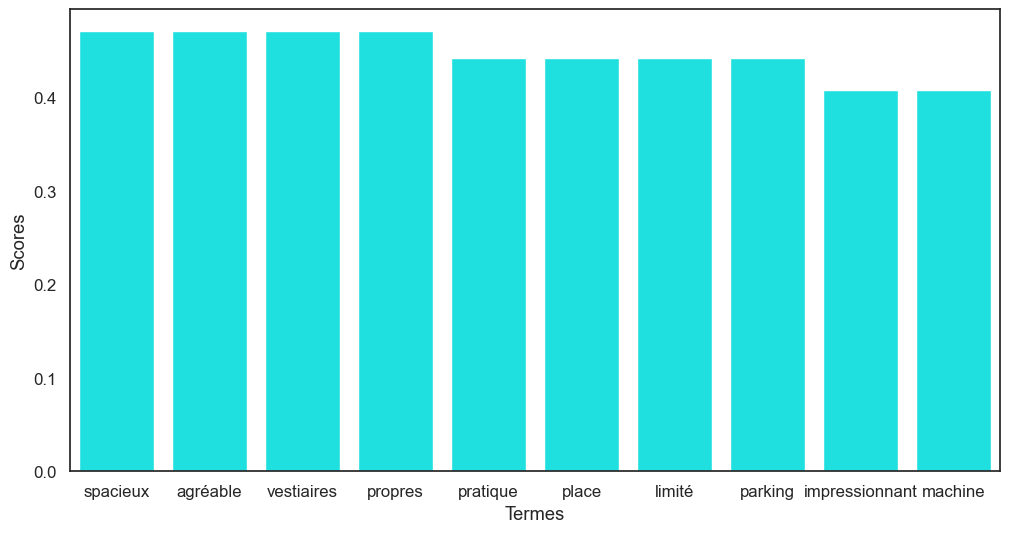

In [8]:
# Visualisation graphique des termes importantes
sns.set(style='white',palette='deep',font_scale=1.1)
plt.figure(figsize=(12, 6))
sns.barplot(x='Termes',y='Scores', data=datatf, color='cyan')
plt.show()

## Entraînement du modèle de VADER pour l'analyse des sentiments

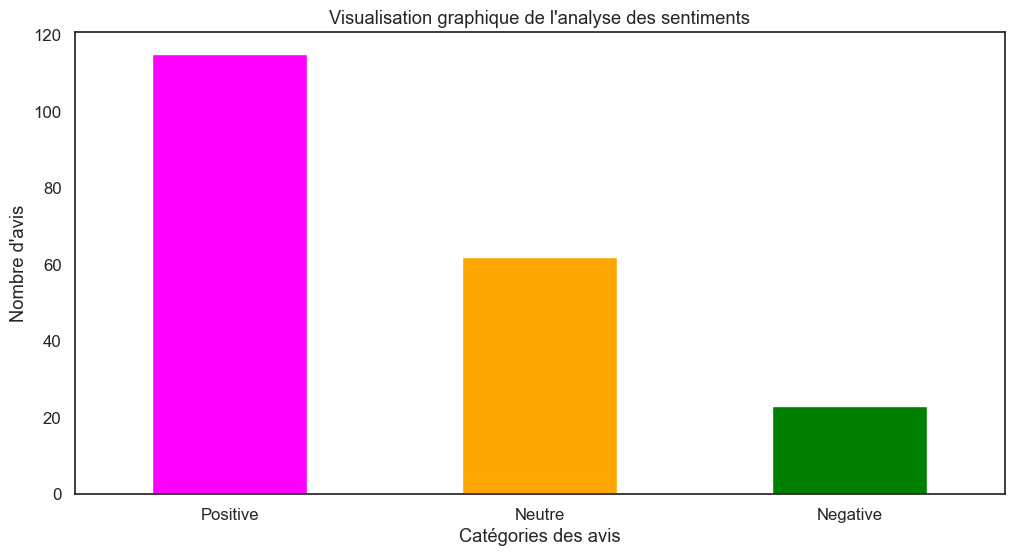

In [9]:
# Entraînement du modèle d'Analyse des sentiments
sentiment = SentimentIntensityAnalyzer()
def analyze_sentiment(text) :
    sentiment_scores = sentiment.polarity_scores(text)
    return sentiment_scores['compound']
avissportif['stop_words'] = avissportif['tokens'].apply(lambda y : ' '.join(y))
avissportif['polarity']=avissportif['stop_words'].apply(analyze_sentiment)

# Interprétation de l'analyse des sentiments
def interprete(polarity):
    if polarity >= 0.05 :
        return 'Positive'
    elif polarity <= -0.05 :
        return 'Negative'
    else:
        return 'Neutre'

# Visualisation graphique de cette analyse
avissportif['sentiment'] = avissportif['polarity'].apply(interprete)

# Compte des avis par catégories
count_value =avissportif['sentiment'].value_counts()

# Visualisation graphique
plt.figure(figsize=(12,6))
count_value.plot(kind='bar', color=['magenta','orange','green'])
plt.xlabel('Catégories des avis')
plt.ylabel("Nombre d'avis")
plt.title("Visualisation graphique de l'analyse des sentiments")
plt.xticks(rotation=0)
plt.show()



## Modélisation des sujets avec LDA

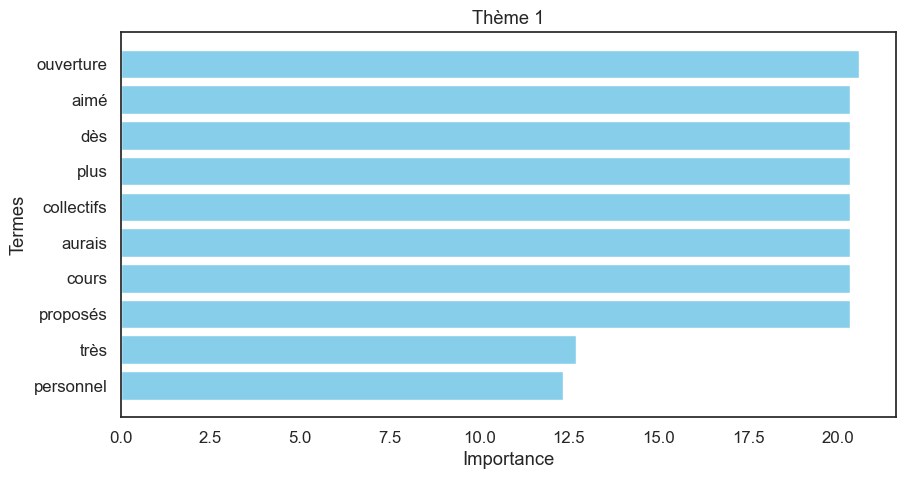

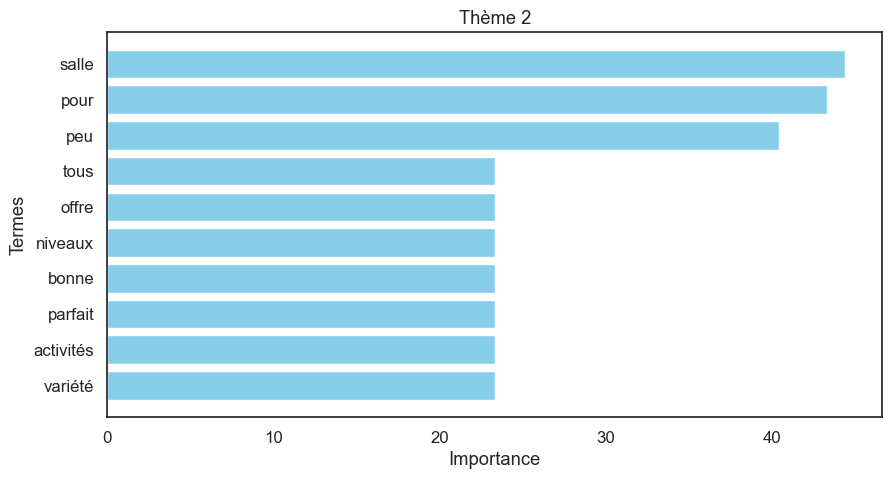

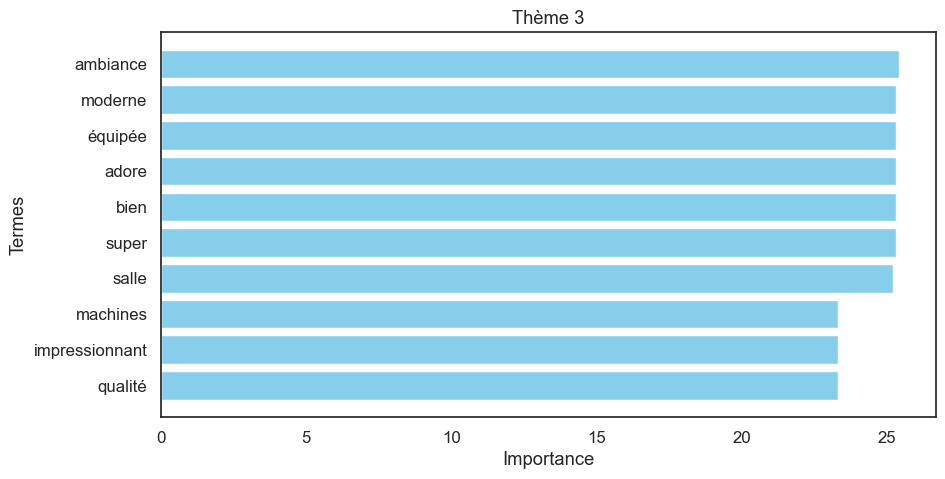

In [12]:
# Stop-words à supprimer
stop_words = ["le", "la", "les", "de", "des", "et", "en", "un", "une", "c", "est", 'j', 'l', 'sont', 'que', 'ai']

# Vectorisation des avis pour LDA
count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=1000)  # Utilisez stop_words comme argument nommé
count_matrix = count_vectorizer.fit_transform(avissportif['stop_words'])  # Correction de l'argument

# Modèle LDA
lda = LatentDirichletAllocation(n_components=3, random_state=42)  # 3 thèmes
lda.fit(count_matrix)

# Extraction des thèmes
terms = count_vectorizer.get_feature_names_out()

# Graphique des thèmes (poids des mots)
for idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-10:]
    plt.figure(figsize=(10, 5))
    plt.barh([terms[i] for i in top_indices], topic[top_indices], color='skyblue')
    plt.title(f"Thème {idx + 1}")
    plt.xlabel("Importance")
    plt.ylabel("Termes")
    plt.show()


## Analyse des émtions

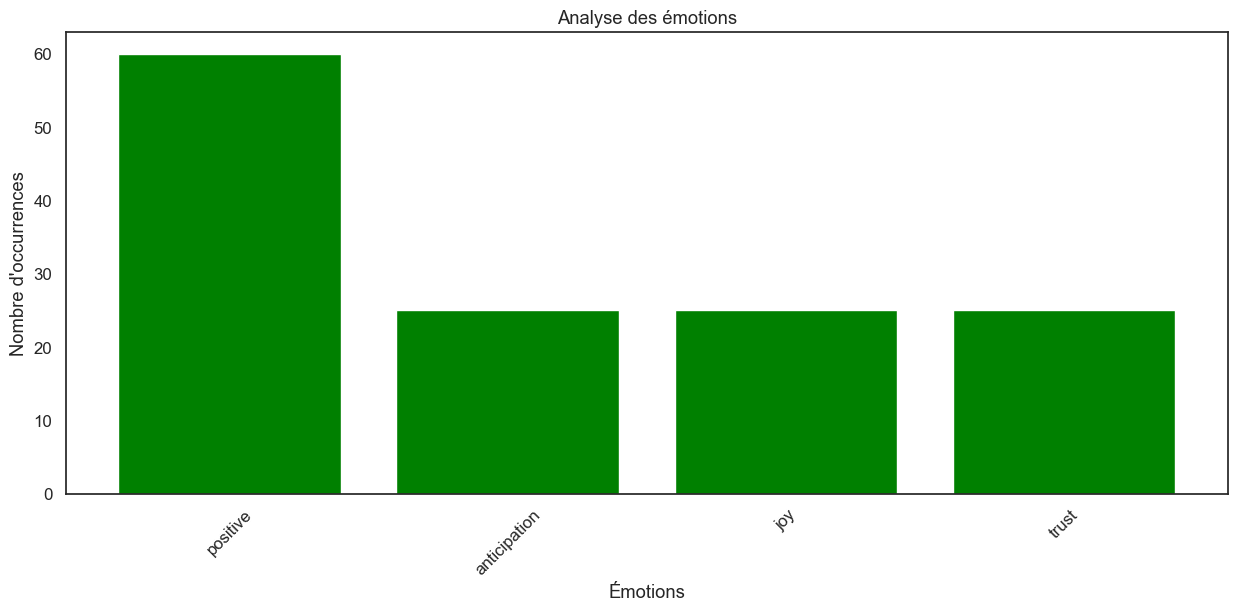

In [11]:
# Fonction pour analyser les émotions
def analyze_emotions(text):
    emotion_analysis = NRCLex(text)
    return emotion_analysis.raw_emotion_scores

# Application sur les avis (Exemple fictif)
avissportif['emotions'] = avissportif['stop_words'].apply(analyze_emotions)

# Agrégation des émotions
emotion_counts = Counter()
for emotions in avissportif['emotions']:
    emotion_counts.update(emotions)

# Visualisation des émotions
plt.figure(figsize=(15, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='green')
plt.xlabel('Émotions')
plt.ylabel("Nombre d'occurrences")
plt.title("Analyse des émotions")
plt.xticks(rotation=45)
plt.show()